In [1]:
using Unitful
using Statistics
using StatsBase
using Plots

Simulation space constants

In [2]:
N_particles = 1_000_00
n = 0.02u"1/m^3" # number density
V = N_particles/n # volume of the system
Nx = 20; Ny = 20; Nz = 20
V_box = V/(Nx*Ny*Nz)
L_box = V_box^(1/3)
Lx = Nx*L_box; Ly = Ny*L_box; Lz = Nz*L_box

170.9975946676697 m

In [3]:
V

5.0e6 m^3

Particle constants

In [4]:
ϵ = 0.6 # coefficient of restitution
R = 0.05u"m" # radius of a particle
ρ = 900u"kg/m^3" # mass density (ice)
m = (4π/3)*ρ*R^3 # mass of a particle

0.4712388980384691 kg

Initial conditions

In [5]:
T₀ = 10.0u"kg*m^2/s^2" # initial temperature
T = T₀ # current temperature
t = 0.0u"s" # simulations time
Δt = 0.1u"s" # time step (adaptive)
Nc = 0 # cumulative number of collisions

0

Simulation constants

In [6]:
C_vmax = 5.0
C_ncoll = 4π*R^2/V_box

5.026548245743669e-5 m^-1

Data structures

In [7]:
rx = Lx*rand(N_particles)
ry = Ly*rand(N_particles)
rz = Lz*rand(N_particles)

vx = randn(N_particles).*sqrt(T₀/m)
vy = randn(N_particles).*sqrt(T₀/m)
vz = randn(N_particles).*sqrt(T₀/m)

vx .-= mean(vx)
vy .-= mean(vy)
vz .-= mean(vz)

100000-element Vector{Quantity{Float64, 𝐋 𝐓^-1, Unitful.FreeUnits{(m, s^-1), 𝐋 𝐓^-1, nothing}}}:
  -1.1707064856981588 m s^-1
    6.328829950031508 m s^-1
   2.6206642757921874 m s^-1
  -2.3868173887248743 m s^-1
   -7.244455139351988 m s^-1
    2.042776524402216 m s^-1
    4.968021600881004 m s^-1
  -3.6563074776204942 m s^-1
    4.795073232647935 m s^-1
  -1.7909793242399954 m s^-1
                           ⋮
  -0.9369102809754439 m s^-1
      0.7669119033785 m s^-1
   -4.012807209932476 m s^-1
   0.9781077398342859 m s^-1
  -12.930564101532733 m s^-1
   -4.279529407559852 m s^-1
   0.6518408073929518 m s^-1
 -0.09171869326981541 m s^-1
     8.85927634091853 m s^-1

In [8]:
T₀ = m*mean(vx.^2+vy.^2+vz.^2)/3
T = T₀

10.044098118987913 kg m^2 s^-2

In [9]:
box_vmax = Array{Float64, 3}(undef, (Nx,Ny,Nz)).*u"m/s"
box_nc_error = Array{Float64, 3}(undef, (Nx,Ny,Nz))
box_particles = Array{Vector{Int64}, 3}(undef, (Nx,Ny,Nz))
for idx in CartesianIndices(box_particles)
    box_vmax[idx] = 0.0u"m/s"
    box_nc_error[idx] = 0.0
    box_particles[idx] = Vector{Int64}(undef, 0)    
end

In [10]:
function set_system_state()
    T = m*mean(vx.^2+vy.^2+vz.^2)/3
    for idx in CartesianIndices(box_particles)
        box_particles[idx] = Vector{Int64}(undef, 0)
    end

    for p_idx in 1:N_particles
        i = Int(1+floor(rx[p_idx] / L_box))
        j = Int(1+floor(ry[p_idx] / L_box))
        k = Int(1+floor(rz[p_idx] / L_box))
        append!(box_particles[i,j,k], p_idx)
    end
    
    for (idx, box_list) in pairs(box_particles)
        if isempty(box_list)
            temperature_box = 0.0u"kg*m^2/s^2"
        else
            temperature_box = m*mean(vx[box_list].^2+vy[box_list].^2+vz[box_list].^2)/3
        end
        v_thermal = sqrt(2*temperature_box/m)        
        box_vmax[idx] = C_vmax * v_thermal
    end
    return T
end

set_system_state (generic function with 1 method)

In [11]:
set_system_state()

10.044098118987913 kg m^2 s^-2

In [12]:
function translations()
    for p_idx in 1:N_particles
        rx[p_idx] = mod.(rx[p_idx] .+ vx[p_idx]*Δt .+ Lx, Lx)
        ry[p_idx] = mod.(ry[p_idx] .+ vy[p_idx]*Δt .+ Ly, Ly)
        rz[p_idx] = mod.(rz[p_idx] .+ vz[p_idx]*Δt .+ Lz, Lz)
    end        
end

translations (generic function with 1 method)

In [13]:
function binary_collision(p1, p2, vmax)
    Δvx = vx[p1] - vx[p2]
    Δvy = vy[p1] - vy[p2]
    Δvz = vz[p1] - vz[p2]
    # generate a random unit vector
    ϕ = 2π*rand()
    cosθ = 2*rand()-1
    sinθ = sqrt(1-cosθ^2)
    nx = cos(ϕ)*sinθ
    ny = sin(ϕ)*sinθ
    nz = cosθ
    Δv_norm = Δvx*nx + Δvy*ny + Δvz*nz
    r = rand()
    if abs(Δv_norm) < r*vmax
        return 0
    else
        h = (1+ϵ)*Δv_norm/2
        vx[p1] -= h*nx; vy[p1] -= h*ny; vz[p1] -= h*nz
        vx[p2] += h*nx; vy[p2] += h*ny; vz[p2] += h*nz
        return 1
    end
end

binary_collision (generic function with 1 method)

In [14]:
function collisions(Δt)
    n_collisions = 0
    for (idx, box_list) in pairs(box_particles)
        n_box_particles = size(box_list,1)        
        if n_box_particles > 1
            Nc_float = C_ncoll*n_box_particles*(n_box_particles-1)*box_vmax[idx]*Δt+box_nc_error[idx]            
            Nc = Int(floor(Nc_float))
            box_nc_error[idx] = Nc_float - Nc
            for coll_idx in 1:Nc
                p1, p2 = samplepair(box_list)
                n_collisions += binary_collision(p1, p2, box_vmax[idx])
            end
        end
    end
    return n_collisions
end

collisions (generic function with 1 method)

In [15]:
function make_step()
    T = set_system_state()
    v_thermal = sqrt(2*T/m)
    Δt = L_box / (C_vmax*v_thermal)
    nc = collisions(Δt)
    translations()
    return (Δt, nc, T)
end

make_step (generic function with 1 method)

In [16]:
t_sim = 0u"s"
nc_sim = 0
T_sim = T₀
t_end = 100.0u"s"
time_arr = Vector{Float64}(undef, 0)*u"s"
temp_arr = Vector{Float64}(undef, 0)*u"kg*m^2/s^2"
ncol_arr = Vector{Int64}(undef, 0)

append!(time_arr, t_sim)
append!(temp_arr, T_sim)
append!(ncol_arr, nc_sim)

while t_sim < t_end    
    dt, nc, temp = make_step()    
    t_sim += dt
    nc_sim += nc    
    append!(time_arr, t_sim)
    append!(temp_arr, temp)
    append!(ncol_arr, nc_sim)
end

In [17]:
function temperature_haff(t)
    tc_inv = (8/3)*(1-ϵ^2)*n*R^2*sqrt(π*T₀/m)
    return T₀./(1 .+ t*tc_inv).^2
end

function ncol_analytic(t)
    C = (1-ϵ^2)/3
    nu_c = 8*n*R^2*sqrt(π*T₀/m)
    return (N_particles/C)*log.(1 .+ C*nu_c*t)
end

ncol_analytic (generic function with 1 method)

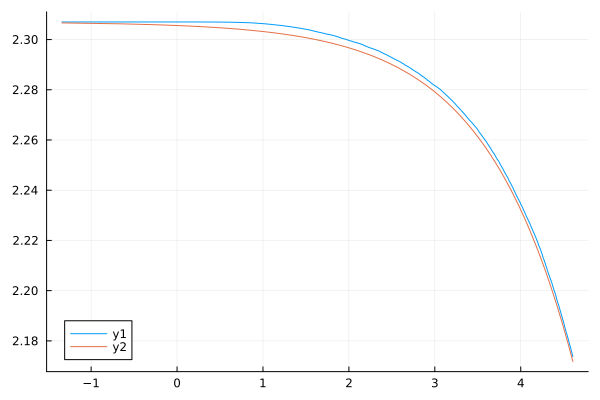

In [18]:
tn = 1.0u"s"
Tn = 1.0u"kg*m^2/s^2"
plot(log.(time_arr/tn), log.(temp_arr/Tn))
plot!(log.(time_arr/tn), log.(temperature_haff(time_arr)/Tn))

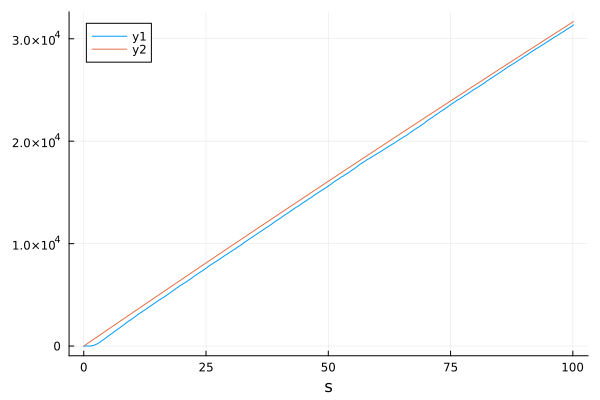

In [19]:
plot(time_arr, ncol_arr)
plot!(time_arr, ncol_analytic(time_arr))